In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3

In [44]:
def comparison(strain, sniffles_data, pav_data, paftools_data, SV, buffer=100):
    
    # Read in data
    sniffles_data_df = pd.read_csv(sniffles_data, sep="\t", header=0, names=["CHROM", "START", "END", "SV_type", "STRAIN"])
    pav_data_df = pd.read_csv(pav_data, sep="\t", header=0, names=["CHROM", "START", "END", "SV_type", "STRAIN"])
    paftools_data_df = pd.read_csv(paftools_data, sep="\t", header=0, names=["CHROM", "START", "END", "SV_type", "STRAIN"])

    if SV not in {"DEL", "INS", "SNP"}:

        # Filter by strain, SV type, and remove MtDNA
        def filter_data(df, strain, sv_type):
            return df[(df['STRAIN'] == strain) & (df["SV_type"] == sv_type) & (~df["CHROM"].str.contains("MtDNA", case=False, na=False))]

        sniffles_data_df_filt = filter_data(sniffles_data_df, strain, SV)
        pav_data_df_filt = filter_data(pav_data_df, strain, SV)

        # Apply buffer: bin START positions within ±buffer range
        def bin_start_positions(df, buffer):
            df["START_BINNED"] = (df["START"] // buffer) * buffer  # Round down to nearest buffer interval (e.g. 1220 == 1200; 1299 == 1200)
            return df

        sniffles_data_df_filt = bin_start_positions(sniffles_data_df_filt, buffer)
        pav_data_df_filt = bin_start_positions(pav_data_df_filt, buffer)

        # Convert START positions to Mb
        for df in [sniffles_data_df_filt, pav_data_df_filt]:
            df["START_Mb"] = df["START"] * 1e-6  
            df["START_BINNED_MB"] = df["START_BINNED"] * 1e-6 

        # Assign tool names
        sniffles_data_df_filt["TOOL"] = "Sniffles"
        pav_data_df_filt["TOOL"] = "PAV"

        plot_df = pd.concat([sniffles_data_df_filt, pav_data_df_filt])

        # Identify shared variants by checking presence in both tools within buffer range
        shared_positions = set(zip(sniffles_data_df_filt["CHROM"], sniffles_data_df_filt["START_BINNED"])) & set(zip(pav_data_df_filt["CHROM"], pav_data_df_filt["START_BINNED"]))

        # Mark variants as shared or private based on presence in both tools
        plot_df["SHARED"] = plot_df.apply(lambda row: "Shared" if (row["CHROM"], row["START_BINNED"]) in shared_positions else "Private", axis=1)

        # Adjust markers for both tools to display on the same position for "Shared" variants
        plot_df["MARKER"] = plot_df["TOOL"] + "_" + plot_df["SHARED"]  # Tool + shared/private indicator

        markers = {"Sniffles_Shared": "s", "Sniffles_Private": "X", "PAV_Shared": "s", "PAV_Private": "X"}

        g = sns.FacetGrid(plot_df, col="CHROM", col_wrap=3, sharex=False, sharey=True, height=5, aspect=1.5)
        g.map_dataframe(sns.scatterplot, x="START_Mb", y="TOOL", hue="TOOL", style="MARKER", markers=markers, alpha=0.7)

        g.set_axis_labels("Genomic Position (Mb)", "Tool")
        g.set_titles(col_template="{col_name}", fontweight='bold', size=14)
        g.add_legend()

        for text in g.legend.texts:
            if text.get_text() == "SHARED":
                text.set_text("Presence")

        plt.suptitle(f"{strain} {SV}'s", fontsize=16, fontweight='bold', y=1.025)
        
        # plt.gcf().savefig(f"/Users/lanceoconnor/Desktop/JohnsHopkins/ANDERSEN_THESIS/projects/gene_annotation/plots/{strain}_SV_tool_comparison.png", dpi=500, bbox_inches="tight")

        plt.show()

    
    # else:
    #     # Filter by strain, SV type, and remove MtDNA
    #     def filter_data(df, strain, sv_type):
    #         return df[(df['STRAIN'] == strain) & (df["SV_type"] == sv_type) & (~df["CHROM"].str.contains("MtDNA", case=False, na=False))]

    #     sniffles_data_df_filt = filter_data(sniffles_data_df, strain, SV)
    #     pav_data_df_filt = filter_data(pav_data_df, strain, SV)
    #     paftools_data_df_filt = filter_data(paftools_data_df, strain, SV)

    #     # Apply buffer: bin START positions within ±buffer range
    #     def bin_start_positions(df, buffer):
    #         df["START_BINNED"] = (df["START"] // buffer) * buffer  # Round down to nearest buffer interval (e.g. 1220 == 1200; 1299 == 1200)
    #         return df

    #     sniffles_data_df_filt = bin_start_positions(sniffles_data_df_filt, buffer)
    #     pav_data_df_filt = bin_start_positions(pav_data_df_filt, buffer)
    #     paftools_data_df_filt = bin_start_positions(paftools_data_df_filt, buffer)

    #     # Convert START positions to Mb
    #     for df in [sniffles_data_df_filt, pav_data_df_filt, paftools_data_df_filt]:
    #         df["START_Mb"] = df["START"] * 1e-6  
    #         df["START_BINNED_MB"] = df["START_BINNED"] * 1e-6 

    #     # Assign tool names
    #     sniffles_data_df_filt["TOOL"] = "Sniffles"
    #     pav_data_df_filt["TOOL"] = "PAV"
    #     paftools_data_df_filt["TOOL"] = "Paftools"

    #     plot_df = pd.concat([sniffles_data_df_filt, pav_data_df_filt, paftools_data_df_filt])

    #     # Identify shared/private SVs using binned positions
    #     grouped = plot_df.groupby(["CHROM", "START_BINNED"])["TOOL"].transform('count')
    #     plot_df["SHARED"] = grouped.apply(lambda x: "Shared" if x > 1 else "Private")

    #     markers = {"Shared": "s", "Private": "X"}
    #     g = sns.FacetGrid(plot_df, col="CHROM", col_wrap=3, sharex=False, sharey=True, height=5, aspect=1.5)
    #     g.map_dataframe(sns.scatterplot, x="START_Mb", y="TOOL", hue="TOOL", style="SHARED", palette="dark", alpha=0.7, markers=markers)

    #     g.set_axis_labels("Genomic Position (Mb)", "Tool")
    #     g.set_titles(col_template="{col_name}", fontweight='bold', size=14)
    #     g.add_legend()

    #     for text in g.legend.texts:
    #         if text.get_text() == "SHARED":
    #             text.set_text("Presence")

    #     plt.suptitle(f"{strain} {SV}'s", fontsize=16, fontweight='bold', y=1.025)
        
    #     # plt.gcf().savefig(f"/Users/lanceoconnor/Desktop/JohnsHopkins/ANDERSEN_THESIS/projects/gene_annotation/plots/{strain}_SV_tool_comparison.png", dpi=500, bbox_inches="tight")
    #     plt.tight_layout()
    #     plt.show()

/var/folders/zb/zjdjqyj90wj8vkngpmq9_8vw0000gn/T/ipykernel_38953/997897968.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["START_BINNED"] = (df["START"] // buffer) * buffer  # Round down to nearest buffer interval (e.g. 1220 == 1200; 1299 == 1200)
/var/folders/zb/zjdjqyj90wj8vkngpmq9_8vw0000gn/T/ipykernel_38953/997897968.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["START_BINNED"] = (df["START"] // buffer) * buffer  # Round down to nearest buffer interval (e.g. 1220 == 1200; 1299 == 1200

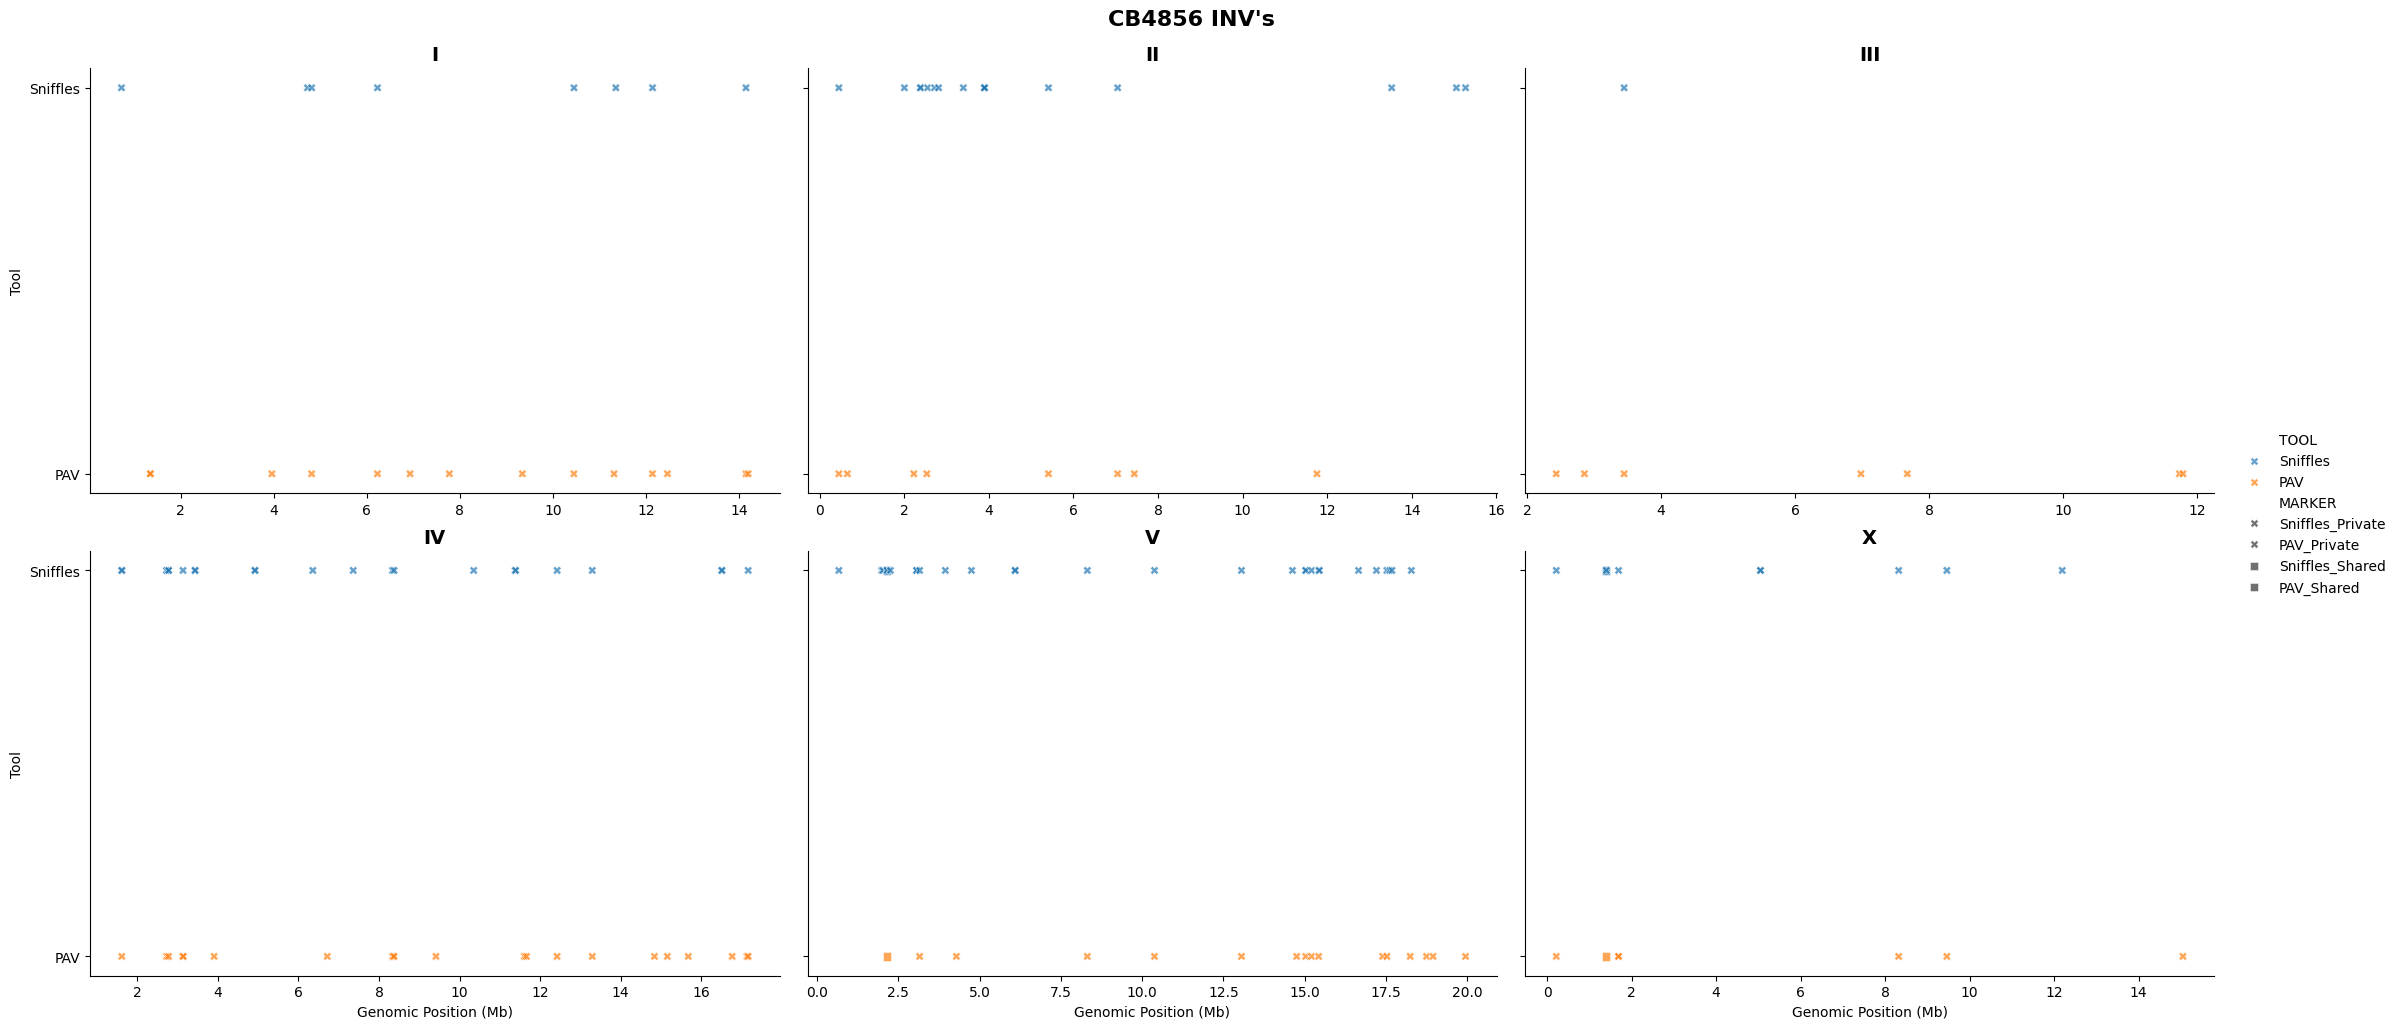

In [45]:
comparison("CB4856","/Users/lanceoconnor/Desktop/JohnsHopkins/ANDERSEN_THESIS/projects/gene_annotation/processed_data/individual_concat.tsv","/Users/lanceoconnor/Desktop/JohnsHopkins/ANDERSEN_THESIS/projects/gene_annotation/processed_data/pavCB4856.tsv","/Users/lanceoconnor/Desktop/JohnsHopkins/ANDERSEN_THESIS/projects/gene_annotation/processed_data/CB4856.paftools.tsv","INV")

In [ ]:
'''
# Shared call on CHROM X:
X	1399485	1404657	INV	CB4856 - pav
X	1399490	1406074	INV	CB4856 - sniffles

V	2153052	2155266	INV	CB4856 - pav
V	2153054	2153975	INV	CB4856 - sniffles


# Isolated calls 
III	3448102	3451308	INV	CB4856 - pav
IV	14837362	14847121	INV	CB4856 - pav
IV	15156644	15163457	INV	CB4856 - pav
IV	15676376	15678718	INV	CB4856 - pav
III	2435777	2437920	INV	CB4856 - pav
III	2856098	2856970	INV	CB4856 - pav
III	3448102	3451308	INV	CB4856 - pav
III	6982129	6985392	INV	CB4856 - pav
III	7673948	7675333	INV	CB4856 - pav
III	11734106	11734857	INV	CB4856 - pav
III	11787512	11792488	INV	CB4856 - pav

III	3448400	3451034	INV	CB4856 - sniffles
II	15055039	15062522	INV	CB4856 - sniffles
II	15271013	15273600	INV	CB4856 - sniffles
II	3395935	3399577	INV	CB4856 - sniffles
II	3886728	3892016	INV	CB4856 - sniffles
II	3894767	3895335	INV	CB4856 - sniffles
II	3895339	3896129	INV	CB4856 - sniffles
II	3895862	3901173	INV	CB4856 - sniffles
'''


SyntaxError: invalid syntax. Perhaps you forgot a comma? (4282624986.py, line 9)